In [97]:
import coffea
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

import awkward as ak
import numpy as np

import hist
from hist import Hist
from hist.intervals import clopper_pearson_interval

import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use(["CMS", "firamath"])


# Trigger efficiency

In [43]:
filename = "Zto2Q-4Jets_HT-400to600.root"
events = NanoEventsFactory.from_root({filename: "Events"}, schemaclass=NanoAODSchema, entry_stop=1000).events()

In [44]:
events.compute()

<NanoEventsArray [<event 1:                286:                1923210>, ..., <event 1:                8823:                59537558>] type='...'>

In [45]:
events.fields

['OtherPV',
 'GenDressedLepton',
 'LHEScaleWeight',
 'LHEWeight',
 'LHEPdfWeight',
 'LHE',
 'SubJet',
 'run',
 'genTtbarId',
 'Rho',
 'Jet',
 'SoftActivityJetHT2',
 'LHEPart',
 'SoftActivityJetHT10',
 'FsrPhoton',
 'Pileup',
 'Generator',
 'SoftActivityJetNjets5',
 'PuppiMET',
 'HLTriggerFirstPath',
 'SV',
 'GenProton',
 'CaloMET',
 'SoftActivityJetNjets10',
 'TrigObj',
 'HTXS',
 'GenJetAK8',
 'bunchCrossing',
 'event',
 'LowPtElectron',
 'FatJet',
 'GenIsolatedPhoton',
 'MET',
 'BeamSpot',
 'GenJet',
 'L1simulation',
 'Electron',
 'GenVisTau',
 'CorrT1METJet',
 'Tau',
 'DeepMETResolutionTune',
 'HLT',
 'ChsMET',
 'GenVtx',
 'DeepMETResponseTune',
 'PV',
 'RawMET',
 'genWeight',
 'SoftActivityJetHT5',
 'PSWeight',
 'Flag',
 'SoftActivityJetHT',
 'luminosityBlock',
 'GenMET',
 'TkMET',
 'GenPart',
 'LHEReweightingWeight',
 'L1Reco',
 'RawPuppiMET',
 'HLTriggerFinalPath',
 'SoftActivityJetNjets2',
 'L1',
 'IsoTrack',
 'Muon',
 'SoftActivityJet',
 'boostedTau',
 'SubGenJetAK8',
 'Photon']

In [46]:
# coffea will read awkward arrays
# [ [1], 
#   [0, 1, 2] 
#   [0, 1] 
# ]
# np will do things like
# [ [1, -999, -999], 
#   [0, 1, 2] 
#   [0, 1, -999] 
# ]
events.GenPart.pdgId.compute()

# array with 1 axis: [ 1, 1, 1 ]
# array with 2 axis: [ [1], [1], [1] ]
# array with 3 axis: [ [[1]], ... ]


<Array [[1, 21, 23, 21, ..., 22, 11, -11], ...] type='103651 * var * int32[...'>

In [47]:
events.GenPart.pdgId[1].compute()

<Array [-1, 2, 23, 21, ..., 11, -11, 11, -11] type='53 * int32[parameters={...'>

In [48]:
ak.to_numpy(events.GenPart.pdgId[0].compute())

array([   1,   21,   23,   21,   21,    1,   23,   23,   23,   23,   23,
         21,   23,    4,   -4,   21,   21,   21,   21,   21,   21,   21,
         21,    4,   -4,  421, -421,    1,   21,   21,   21,   21,   21,
         21,   21,    2,   -1,  111,  -13,   14,   22,   22,   11,  -11],
      dtype=int32)

In [49]:
# count the number of GenParticles for all the events
ak.num(events.GenPart).compute()

<Array [44, 53, 65, 42, 54, 43, ..., 51, 41, 35, 22, 51] type='103651 * int64'>

In [50]:
events.GenPart.pdgId[0].compute().to_numpy()

array([   1,   21,   23,   21,   21,    1,   23,   23,   23,   23,   23,
         21,   23,    4,   -4,   21,   21,   21,   21,   21,   21,   21,
         21,    4,   -4,  421, -421,    1,   21,   21,   21,   21,   21,
         21,   21,    2,   -1,  111,  -13,   14,   22,   22,   11,  -11],
      dtype=int32)

In [51]:
events.HLT.AK8PFJet230_SoftDropMass40.compute()


<Array [False, False, False, ..., False, False] type='103651 * bool[paramet...'>

Still don't know how this works:

In [52]:
mask_gen_particles = events.GenPart.hasFlags(["fromHardProcess", "isLastCopy"])
genparticles_after_mask = events.GenPart[mask_gen_particles]
genparticles_after_mask.pdgId.compute()

<Array [[21, 23, 21, 21, ..., 21, 21, 21], ...] type='103651 * var * int32[...'>

###            Now lets filter our events and particles

In [53]:
#   Filter for the events that pass the trigger
def filter_events(evt):
    # absolute 
    status = evt.HLT.AK8PFJet230_SoftDropMass40.compute()
    # returning events that pass the mask
    return evt[
        (status == True)
    ]

#   Filter for the genparticles that are Z bosons
def getParticles(genparticles, pdgId, flags=['fromHardProcess', 'isLastCopy']):
    # absolute 
    absid = abs(genparticles.pdgId)
    # returning genparticles that pass the mask
    return genparticles[
        (absid == pdgId)
        & genparticles.hasFlags(flags)
    ]

In [54]:
mask_trig = filter_events(events)  # events that pass the trigger
mask_trig.GenPart.pdgId.compute()

<Array [[3, -1, 23, ..., -421, 11, -11], ...] type='9676 * var * int32[para...'>

In [55]:
mask_z = getParticles(mask_trig.GenPart, 23, ['fromHardProcess', 'isLastCopy'])   # Z bosons that pass the trigger
z_bosons = mask_z[:, 0] # take the first Z boson
zboson_pt = z_bosons.pt.compute().to_numpy()


In [56]:
mask_z_noTrig = getParticles(events.GenPart, 23, ['fromHardProcess', 'isLastCopy'])
z_bosons_notrig = mask_z_noTrig[:, 0] # take the first Z boson
zboson_pt_all = z_bosons_notrig.pt.compute().to_numpy()


How to plot arrays

In [57]:
# create axes
zpt_axis = hist.axis.Regular(100, 0, 350, name="zpt", label=r"Z p$_{T}$ GeV")
dataset_axis = hist.axis.StrCategory([], name="dataset", growth=True)
# create a histogram


In [68]:
h_zboson_pt = hist.Hist(zpt_axis)
h_zboson_pt.fill(zboson_pt_np)

Hist(Regular(100, 0, 350, name='zpt', label='Z p$_{T}$ GeV'), storage=Double()) # Sum: 9672.0 (9676.0 with flow)

In [69]:
h_z_pt_notrig = hist.Hist(zpt_axis)
h_z_pt_notrig.fill(zboson_pt_np_nt)

Hist(Regular(100, 0, 350, name='zpt', label='Z p$_{T}$ GeV'), storage=Double()) # Sum: 103646.0 (103651.0 with flow)

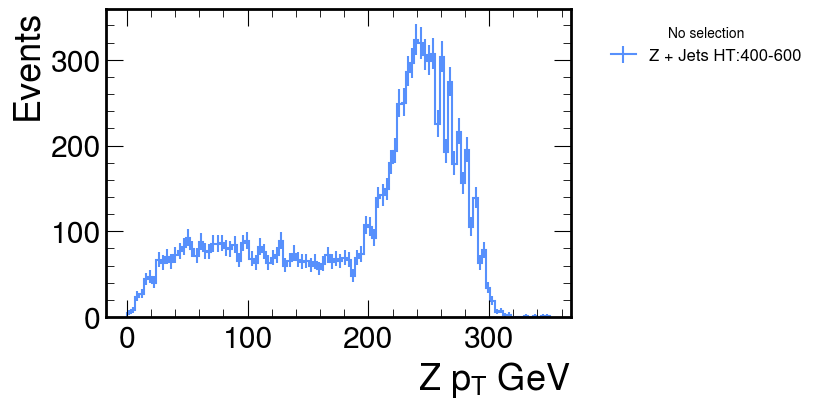

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
hep.histplot(h_zboson_pt, ax=ax, flow="none", label='Z + Jets HT:400-600') # flow =None gets rid of // at the end of the histogram
leg = ax.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_ylabel("Events")
leg.set_title(f"No selection", prop={"size": 10})

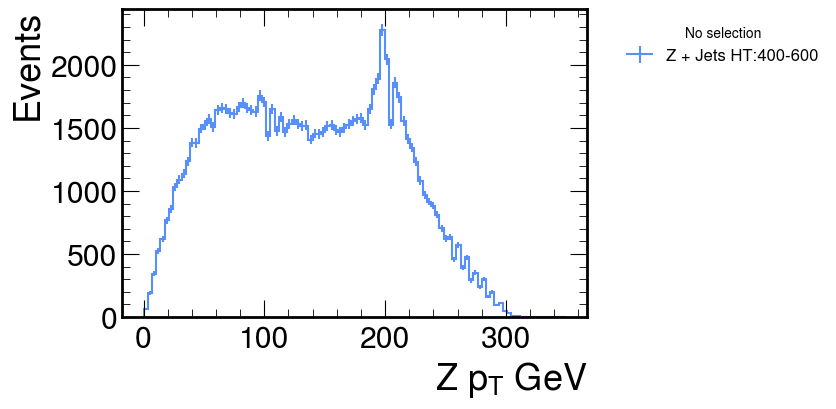

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
hep.histplot(h_z_pt_notrig, ax=ax, flow="none", label='Z + Jets HT:400-600') # flow =None gets rid of // at the end of the histogram
leg = ax.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_ylabel("Events")
leg.set_title(f"No selection", prop={"size": 10})

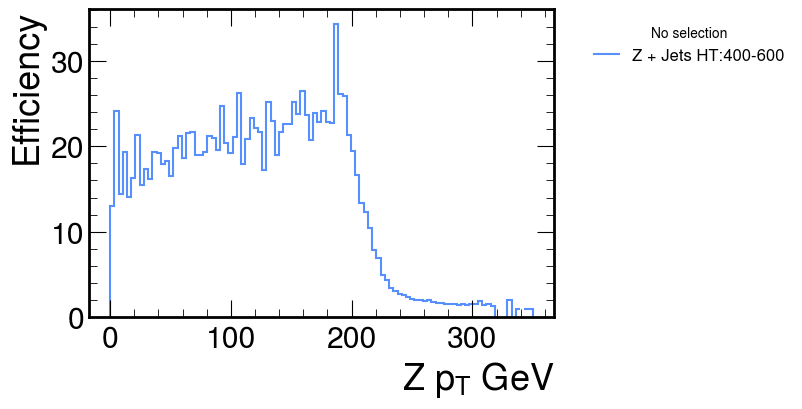

In [77]:
h_eff = h_z_pt_notrig/h_zboson_pt
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
hep.histplot(h_eff, ax=ax, flow="none", label='Z + Jets HT:400-600') # flow =None gets rid of // at the end of the histogram
leg = ax.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_ylabel("Efficiency")
leg.set_title(f"No selection", prop={"size": 10})


In [89]:
h_zboson_pt_2axis = hist.Hist(zpt_axis, dataset_axis)
h_zboson_pt_2axis.fill(zpt=zboson_pt, dataset="zjets-400-600")
h_zboson_pt_2axis


Hist(
  Regular(100, 0, 350, name='zpt', label='Z p$_{T}$ GeV'),
  StrCategory(['zjets-400-600'], growth=True, name='dataset'),
  storage=Double()) # Sum: 9672.0 (9676.0 with flow)

In [90]:
h_zboson_pt_2axis_all = hist.Hist(zpt_axis, dataset_axis)
h_zboson_pt_2axis_all.fill(zpt=zboson_pt_all, dataset="zjets-400-600")
h_zboson_pt_2axis_all

Hist(
  Regular(100, 0, 350, name='zpt', label='Z p$_{T}$ GeV'),
  StrCategory(['zjets-400-600'], growth=True, name='dataset'),
  storage=Double()) # Sum: 103646.0 (103651.0 with flow)

In [88]:
h_zboson_pt_2axis[{"dataset": "zjets-400-600"}]

Hist(Regular(100, 0, 350, name='zpt', label='Z p$_{T}$ GeV'), storage=Double()) # Sum: 103646.0 (103651.0 with flow)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x179508f50>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

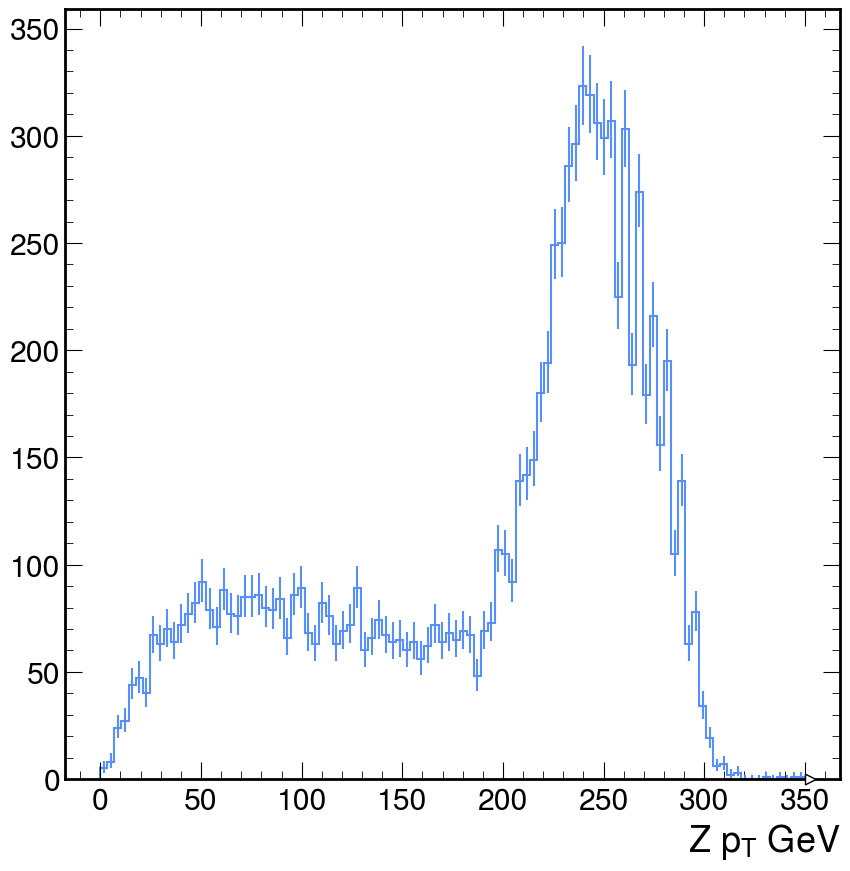

In [91]:
hep.histplot(h_zboson_pt_2axis[{"dataset": "zjets-400-600"}])

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x178f647a0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

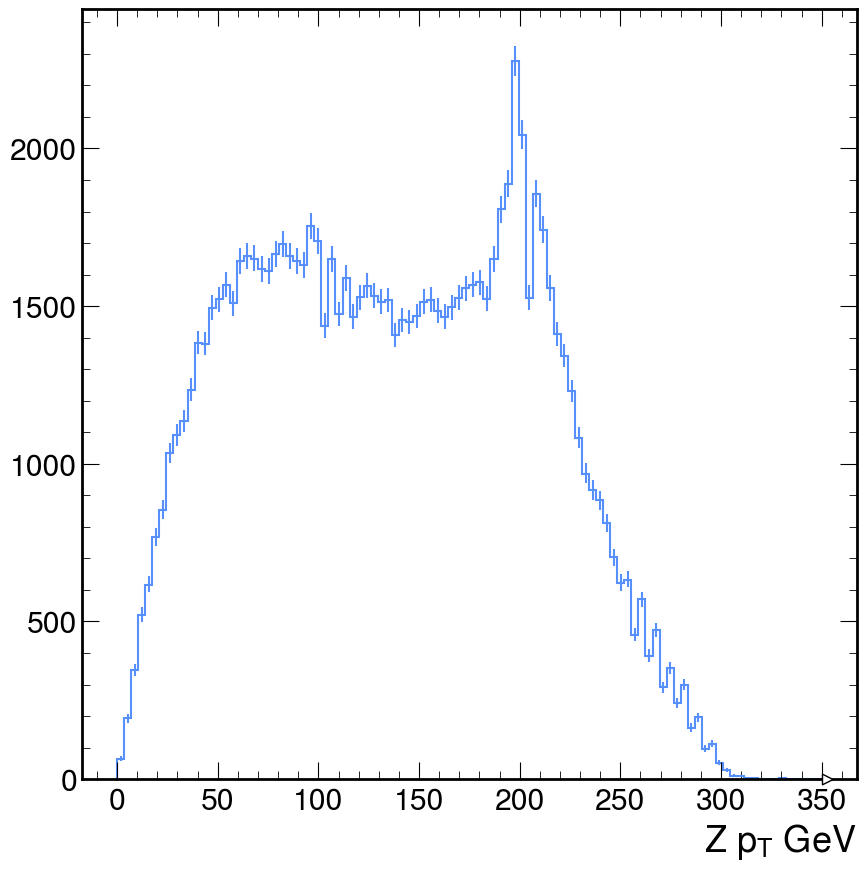

In [116]:
hep.histplot(h_zboson_pt_2axis_all[{"dataset": "zjets-400-600"}])

/var/folders/5l/g72gr7pn1qjfpv9ts3r8m3x80000gn/T/ipykernel_1133/2436152216.py:6: RuntimeWarning: divide by zero encountered in divide
  yerr=abs((clopper_pearson_interval(num.view(),den.view()) - num.view()) / den.view()),
/var/folders/5l/g72gr7pn1qjfpv9ts3r8m3x80000gn/T/ipykernel_1133/2436152216.py:6: RuntimeWarning: invalid value encountered in divide
  yerr=abs((clopper_pearson_interval(num.view(),den.view()) - num.view()) / den.view()),
/var/folders/5l/g72gr7pn1qjfpv9ts3r8m3x80000gn/T/ipykernel_1133/2436152216.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  leg = ax.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc="upper left")


Text(0, 1, 'Efficiency')

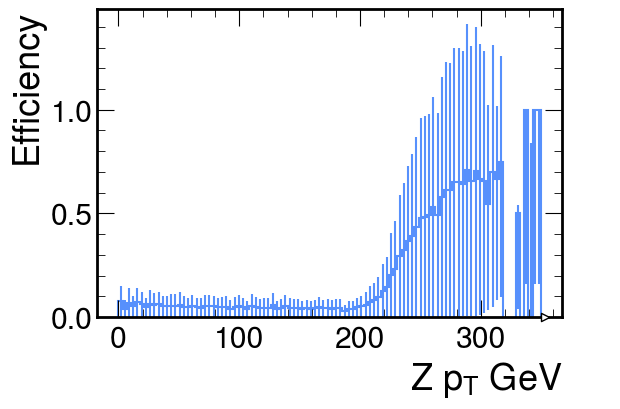

In [120]:
num = h_zboson_pt_2axis[{"dataset": "zjets-400-600"}]
den = h_zboson_pt_2axis_all[{"dataset": "zjets-400-600"}]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
hep.histplot(num / den,
    yerr=abs((clopper_pearson_interval(num.view(),den.view()) - num.view()) / den.view()),
    #ax=ax,
    #flow="none",
)
leg = ax.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_ylabel("Efficiency")
#leg.set_title(f"No selection", prop={"size": 10})


# Documentation:

- hist: https://hist.readthedocs.io/en/latest/user-guide/axes.html
- mplhep: https://mplhep.readthedocs.io/en/latest/api.html